## Imports

In [684]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_absolute_error

pd.options.mode.chained_assignment = None
tf.random.set_seed(8650)

from statsforecast import StatsForecast
from statsforecast.models import SeasonalNaive

import warnings
warnings.filterwarnings("ignore")

# 1. EDA / Preprocessing

In [685]:
# extract the data
df = pd.read_csv("Datasets/Dataframes_one_ex_var/ModelBenchmark_dataframe.csv")
df = pd.read_csv("Datasets/Price_Generation_Load_Solar_Wind.csv", index_col=0, parse_dates=True)
df = pd.read_csv("Datasets/full_2018_2023_prices.csv", parse_dates=True)


In [670]:
df = df.drop(columns=["BE Generation", "BE Load"])
df, df.shape

(                     BE Solar  BE Wind  Price
 2018-01-01 00:00:00       0.0   2253.0   4.74
 2018-01-01 01:00:00       0.0   2247.0   3.66
 2018-01-01 02:00:00       0.0   2220.0   1.26
 2018-01-01 03:00:00       0.0   2174.0 -20.10
 2018-01-01 04:00:00       0.0   2123.0 -31.82
 ...                       ...      ...    ...
 2023-12-31 19:00:00       0.0   4331.0  20.26
 2023-12-31 20:00:00       0.0   4261.0  19.65
 2023-12-31 21:00:00       0.0   4301.0   9.00
 2023-12-31 22:00:00       0.0   4301.0  10.68
 2023-12-31 23:00:00       0.0   4324.0   3.17
 
 [52584 rows x 3 columns],
 (52584, 3))

In [671]:
# return the row in the dataframe that is 728 * 24 values before the datetime index 2023-01-01 00:00:00
end_index = df.loc[df.Date == "2023-01-01 00:00:00"].index[0]
start_index = end_index - 728 * 24
start_date = df.loc[start_index, "Date"]
start_index, end_index, start_date

AttributeError: 'DataFrame' object has no attribute 'Date'

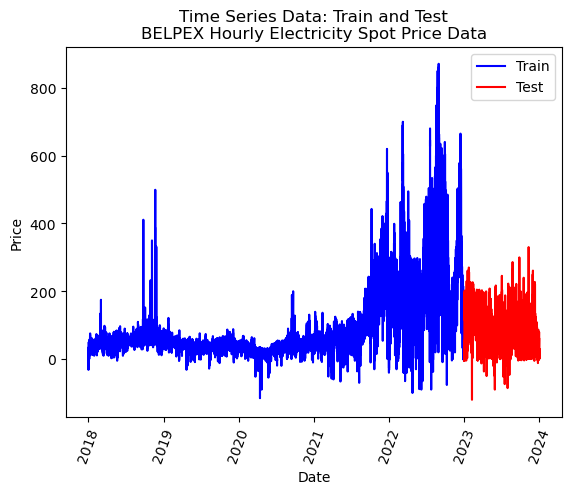

In [686]:
# df["Date"] = df.index 
df["Date"] = pd.to_datetime(df["Date"])
df.index = df["Date"]

# train_df = df[(df['Date'] >= '2021-01-03 00:00:00') & (df['Date'] < '2023-01-01 00:00:00')]
train_df = df[df['Date'] < '2023-01-01 00:00:00']
test_df = df[df['Date'] >= '2023-01-01 00:00:00']


# Plot train dataset in blue
plt.plot(train_df["Date"], train_df["Price"], color='blue', label='Train')

# Plot test dataset in red
plt.plot(test_df["Date"], test_df["Price"], color='red', label='Test')

plt.xlabel('Date')
plt.xticks(rotation=70)
plt.ylabel('Price')
plt.legend()
plt.title('Time Series Data: Train and Test\nBELPEX Hourly Electricity Spot Price Data')
plt.show()

In [687]:
train_df.set_index("Date", inplace=True)
test_df.set_index("Date", inplace=True)
naive_df = test_df.copy()

In [688]:
train_df

,Price
Date,
2018-01-01 00:00:00,4.74
2018-01-01 01:00:00,3.66
2018-01-01 02:00:00,1.26
2018-01-01 03:00:00,-20.10
2018-01-01 04:00:00,-31.82
...,...
2022-12-31 19:00:00,10.55
2022-12-31 20:00:00,5.22
2022-12-31 21:00:00,2.39


In [689]:
# train_df = train_df["Price"]
# test_df = test_df["Price"]
train_data = train_df.values
test_data = test_df.values
# train_data = train_df.values.reshape(-1, 1)
# test_data = test_df.values.reshape(-1, 1)
train_data.shape, test_data.shape

((43824, 1), (8760, 1))

## Different scalar methods

In [690]:
df["Date"] = pd.to_datetime(df["Date"])
df.index = df["Date"]
df.drop("Date", axis=1, inplace=True)

In [691]:
from sklearn.preprocessing import PowerTransformer
from helper_functions.utils import DataScaler
# scale the data
# #IS IT OKAY TO TRANSFORM TEST DATASETSET WITH SCALER FITTED ON TRAIN DATA
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(df.values)
df_scaled = scaler.transform(df.values)
scaler = scaler.fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

# X_scaler = MinMaxScaler(feature_range=(0, 1))
# Y_scaler = MinMaxScaler(feature_range=(0, 1))

# # X_scaler = StandardScaler()
# # Y_scaler = StandardScaler()

# Y_train_scaled = Y_scaler.fit_transform(train_data[:, train_data.shape[1]-1].reshape(-1, 1))
# X_train_scaled = X_scaler.fit_transform(train_data[:, :train_data.shape[1]-1])

# Y_test_scaled = Y_scaler.transform(test_data[:, train_data.shape[1]-1].reshape(-1, 1))
# X_test_scaled = X_scaler.transform(test_data[:, :train_data.shape[1]-1])

# train_data_scaled = np.concatenate((X_train_scaled, Y_train_scaled), axis=1)
# test_data_scaled = np.concatenate((X_test_scaled, Y_test_scaled), axis=1)
train_data_scaled.shape, test_data_scaled.shape
# pt = PowerTransformer(method="yeo-johnson")
# scaler = pt.fit(train_data)
# train_data_scaled = scaler.transform(train_data)
# test_data_scaled = scaler.transform(test_data)

# scaler = DataScaler('Invariant')
# train_data_scaled = scaler.fit_transform(train_data)
# test_data_scaled = scaler.transform(test_data)

((43824, 1), (8760, 1))

## Generating train & test sequences in correct format

In [678]:
# n_lookback = 168  # length of input sequences (lookback period), 7*24H
# n_forecast = 24  # length of output sequences (forecast period), 24H

# def generate_train_pairs(raw_input, n_lookback, n_forecast):
#     # generate the input and output sequences for training data

#     X_train = []
#     Y_train = []

#     # This loop is designed to ensure that we can extract enough input-output pairs from the time series data
#     for i in range(0, len(raw_input) - n_lookback - n_forecast + 1, 24):
#         X_train.append(raw_input[i:i + n_lookback])  # Append a subsequence of length n_lookback from the y dataset
#         Y_train.append(raw_input[i + n_lookback:i + n_lookback + n_forecast])  # Corresponding output sequence

#     X_train = np.array(X_train)
#     Y_train = np.array(Y_train)
#     return X_train, Y_train[:, :, -1:]

# X_train, Y_train = generate_train_pairs(train_data_scaled, n_lookback, n_forecast)
# X_train.shape, Y_train.shape

In [693]:
univariate = True

n_lookback = 168  # length of input sequences (lookback period), 7*24H
n_forecast = 24  # length of output sequences (forecast period), 24H

def univariate_createXY(dataset,n_past=168, n_future=24):
    X_train = []
    Y_train = []
    for i in range(n_past, len(dataset), n_future):
            X_train.append(dataset[i - n_past:i])
            Y_train.append(dataset[i:i+n_future])
    return np.array(X_train),np.array(Y_train)

def createXY(dataset,n_past=168, n_future=24):
    X_train = []
    Y_train = []
    for i in range(n_past, len(dataset), n_future):
            X_train.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            Y_train.append(dataset[i:i+n_future,dataset.shape[1]-1])
    return np.array(X_train),np.array(Y_train)

if univariate == True:
    X_train,Y_train= univariate_createXY(train_data_scaled,n_lookback,n_forecast)
    X_test,Y_test=univariate_createXY(test_data_scaled,n_lookback,n_forecast)
else:
    X_train,Y_train= createXY(train_data_scaled,n_lookback,n_forecast)
    X_test,Y_test=createXY(test_data_scaled,n_lookback,n_forecast)
    
X_train.shape,Y_train.shape,X_test.shape, Y_test.shape

((1819, 168, 1), (1819, 24, 1), (358, 168, 1), (358, 24, 1))

Samenstelling van X_test
- Eerste 6 dagen in test set heeft onvoldoende prijshistorie, dus vanaf dag 7 kan je forecast maken voor dag 8

In [661]:
# # generate the input sequences for test data
# X_test = []

# # Iterate through the data with a step size of 24 hours
# for i in range(0, len(test_data_scaled) - n_lookback + 1, 24):
#     X_test.append(test_data_scaled[i:i + n_lookback])

# X_test = np.array(X_test)
# X_test.shape

## Model setup parameters

In [694]:
regression_type = "Multivariate" if univariate == False else "Univariate"
scaler_type = "MIN MAX (0,1)"
multistep_technique = "Recursive multi-step multi-output"
test_period = "1y"
# train_period = "56D"
lookback_window = n_lookback
forecast_horizon = n_forecast
recalibration = "None"
calibration_window='56D'

# Forecasting

## Naive forecaster
- For rMAE calculation

In [695]:
from helper_functions.utils import naive_forecast

# df = pd.read_csv("Datasets/Dataframes_one_ex_var/ModelBenchmark_dataframe.csv")
# Naive forecaster copy of Jilles, i.e. Similar day model of 7 week prior (section 2.1 paper)

# # Y_pred_naive = [0] + test_data.flatten().tolist()[:-1]
# Y_pred_naive = 24*[np.NAN] + test_data[168:].flatten().tolist()[:-24]
# Y_pred_naive = np.array(Y_pred_naive)
# Y_pred_naive = pd.Series(data=Y_pred_naive)
# Y_pred_naive.fillna(method="backfill", inplace=True)
# Y_pred_naive = Y_pred_naive.to_numpy()
# Y_pred_naive.shape

# model = StatsForecast(models=[SeasonalNaive(season_length=7)],freq='H', n_jobs=-1)
# model.fit(train_df)

Y_pred_naive = naive_forecast(naive_df, m=None, n_prices_day=24)["Price"].to_numpy()
Y_pred_naive.shape

(8592,)

## LSTM: Recalibration code

Steps
- train model on train data
- get the forecasts for next 7 days by shifting window 1 day ahead every time
- evaluate (MAE / RMAE) for each new instance of the 7 days 
- add ground truth data of last 7 days to train set and remove last 7 days
- repeat

In [599]:
# fit the model
model = Sequential()
model.add(LSTM(units=50, activation='tanh', return_sequences=True, input_shape=(n_lookback, 5)))
model.add(LSTM(units=50, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(n_forecast))

# Compile the model
model.compile(loss='mean_absolute_error', optimizer='adam')

# Define the checkpoint
checkpoint = tf.train.Checkpoint(model=model)

mae_list = []
Y_pred_list = []
Y_actual_list = []
recalibration_test = X_test

# Recalibration loop
for week in range(0,len(X_test) - 6, 7):  # Repeat for 7 days, do -6 because the last week isn't fully completed
    # Train the model on the train data
    print("[TRAINING MODEL...]")
    if week==0:
        model.fit(X_train, Y_train, epochs=25, batch_size=32, verbose=1)
    else:
        model.fit(X_train_new, Y_train_new, epochs=10, batch_size=32, verbose=1)
    
    # Get the 24h ahead forecasts for next 7 days
    for day in range(0, 7):
        # Generate forecasts for the next 24 hours
        # Prepare test data for forecasting, e.g., by shifting window
        # Predict
        Y_pred_scaled = model.predict(recalibration_test)
        Y_pred = Y_scaler.inverse_transform(Y_pred_scaled[0].reshape((-1,1))) #reshape to get column vector!
        Y_actual = test_data[168:][((week+day)*24):(((week+day+1)*24))][:, -1].flatten()
        # Evaluate (MAE / RMAE) for each new forecast horizon (24 hours)
        # Replace the evaluation code with your own metric calculation
        # mae = np.mean(np.abs(Y_pred - Y_actual))
        print(Y_actual.shape, Y_pred.shape)
        if Y_actual.shape[0] == 0:
            continue
        mae = mean_absolute_error(Y_actual, Y_pred)
        rmae = np.sqrt(np.mean(np.square(Y_pred - Y_actual)))
        print(f"Week {round(week/7)} Day {day}: MAE = {mae}, RMAE = {rmae}")
        mae_list.append(mae)
        Y_pred_list.append(Y_pred)
        Y_actual_list.append(Y_actual)
        if len(recalibration_test) > 1:
            recalibration_test = recalibration_test[1:]
        else:
            continue
    # Add ground truth data of last 7 days to train set and remove last 7 days
    train_data_scaled = np.concatenate((train_data_scaled, test_data_scaled[24*7*(week):24*(week+1)*7]), axis=0)
    train_data_scaled = train_data_scaled[7*24:,:]
    X_train_new, Y_train_new = createXY(train_data_scaled, n_lookback, n_forecast)
    # X_train_new = np.expand_dims(X_train_new, axis=2)
    # Y_train_new = np.expand_dims(Y_train_new, axis=2)
    print(X_train_new.shape, Y_train_new.shape)
    # Save the model weights
    checkpoint.save('./checkpoints/my_checkpoint')
    
    # Restore the model weights before the next iteration
    # This ensures that we are only updating the weights slightly
    checkpoint.restore(tf.train.latest_checkpoint('./checkpoints/'))

[TRAINING MODEL...]
Epoch 1/25


ValueError: in user code:

    File "c:\Users\r0776327\AppData\Local\miniconda3\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\r0776327\AppData\Local\miniconda3\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\r0776327\AppData\Local\miniconda3\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\r0776327\AppData\Local\miniconda3\lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\r0776327\AppData\Local\miniconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\r0776327\AppData\Local\miniconda3\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_41" is incompatible with the layer: expected shape=(None, 168, 5), found shape=(None, 168, 3)


In [175]:
# Calculate the mean MAE and RMAE
mae_pred = np.mean(mae_list)
mae_naive = mean_absolute_error(np.concatenate(Y_actual_list), Y_pred_naive[:-24])
mae_pred, mae_naive

(29.98177413427623, 32.21380368814193)

### Visualize output

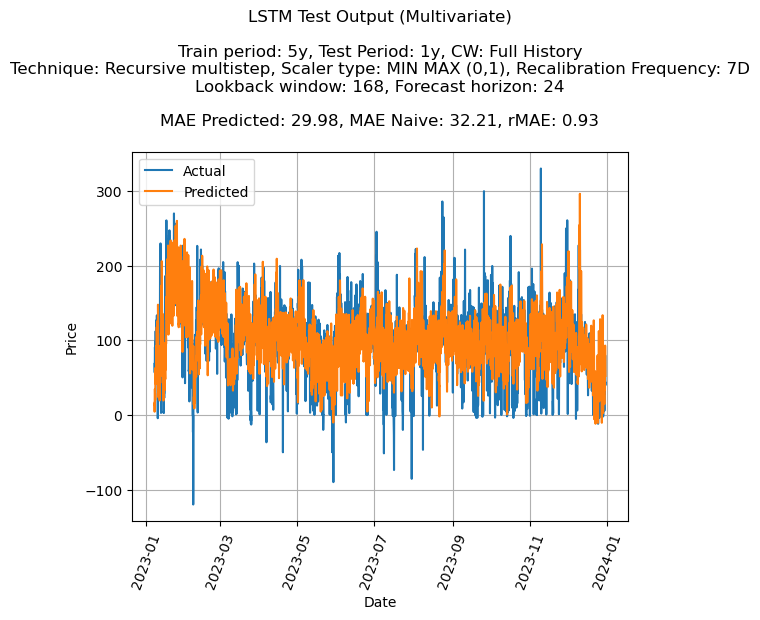

In [179]:
x_ticks = test_df.index[168:-24]

title = f"""LSTM Test Output ({regression_type})\n
Train period: {train_period}, Test Period: {test_period}, CW: {calibration_window}
Technique: {multistep_technique}, Scaler type: {scaler_type}, Recalibration Frequency: {recalibration}
Lookback window: {lookback_window}, Forecast horizon: {forecast_horizon}\n
MAE Predicted: {round(mae_pred,2)}, MAE Naive: {round(mae_naive, 2)}, rMAE: {round(mae_pred/mae_naive, 2)}
"""

plt.plot(x_ticks, np.concatenate(Y_actual_list), label="Actual")
plt.plot(x_ticks, np.concatenate(Y_pred_list), label="Predicted")
# plt.plot(x_ticks, Y_pred_naive, label="Persistence", alpha=0.5)
plt.title(title)
plt.legend()
plt.xticks(rotation=70)
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()

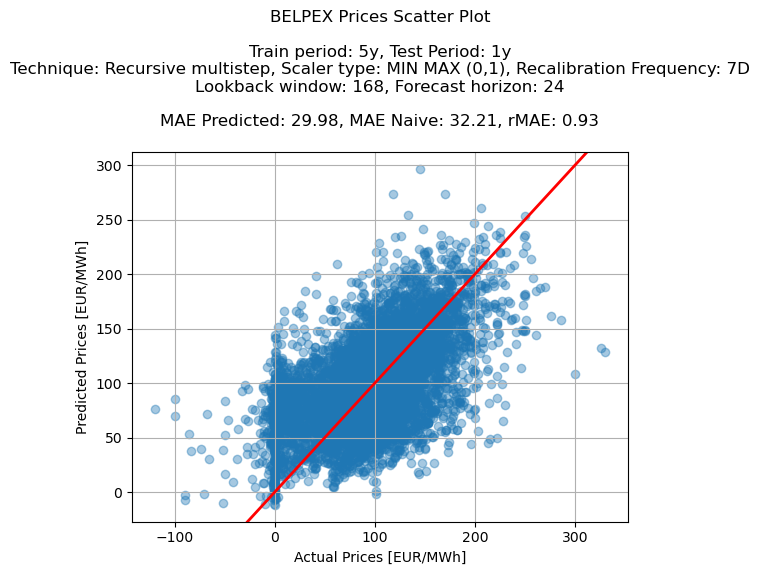

In [177]:
fig, ax = plt.subplots()

title =f"""
Train period: {train_period}, Test Period: {test_period}
Technique: {multistep_technique}, Scaler type: {scaler_type}, Recalibration Frequency: {recalibration}
Lookback window: {lookback_window}, Forecast horizon: {forecast_horizon}\n
MAE Predicted: {round(mae_pred,2)}, MAE Naive: {round(mae_naive, 2)}, rMAE: {round(mae_pred/mae_naive, 2)}
"""

ax.axline((0, 0), slope=1, color='r', linewidth=2)
ax.scatter(x=np.concatenate(Y_actual_list), y=np.concatenate(Y_pred_list), alpha = 0.4)
ax.grid(True)
ax.set_xlabel("Actual Prices [EUR/MWh]")
ax.set_ylabel("Predicted Prices [EUR/MWh]")
plt.title(f"BELPEX Prices Scatter Plot\n{title}")
plt.show()

## LSTM: No Recalibration

In [696]:
import time
# Start the timer
start_time = time.time()

# fit the model
model = Sequential()
model.add(LSTM(units=100, activation='tanh', return_sequences=True, input_shape=(n_lookback, X_train.shape[2])))
model.add(LSTM(units=100, activation='tanh', return_sequences=False))
# model.add(Dropout(0.2))
model.add(Dense(n_forecast, activation='linear'))

model.compile(loss='mae', optimizer='adam', metrics=["mean_squared_error", "mean_absolute_error"])
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=1, validation_split=0.1)

# Calculate the elapsed time
elapsed_time = time.time() - start_time
print(f"Model training took {elapsed_time} seconds.")

Epoch 1/50
52/52 [==============================] - 8s 104ms/step - loss: 0.0396 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0396 - val_loss: 0.0659 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0659
Epoch 2/50
52/52 [==============================] - 5s 101ms/step - loss: 0.0175 - mean_squared_error: 9.6208e-04 - mean_absolute_error: 0.0175 - val_loss: 0.0633 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0633
Epoch 3/50
52/52 [==============================] - 5s 100ms/step - loss: 0.0171 - mean_squared_error: 9.1946e-04 - mean_absolute_error: 0.0171 - val_loss: 0.0623 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0623
Epoch 4/50
52/52 [==============================] - 5s 98ms/step - loss: 0.0165 - mean_squared_error: 9.0304e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0624 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0624
Epoch 5/50
52/52 [==============================] - 5s 99ms/step - loss: 0.0165 - mea

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


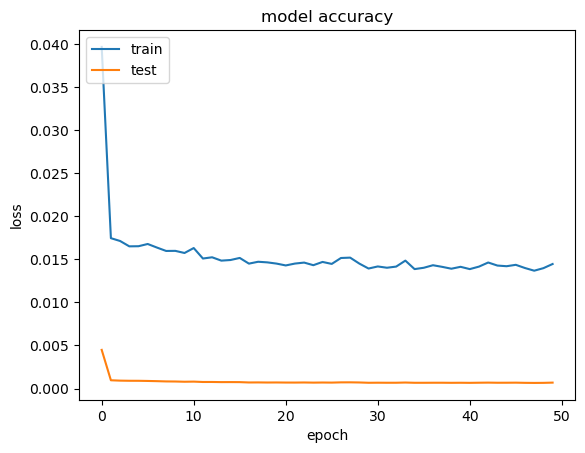

In [697]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [698]:
# generate predictions
Y_pred_scaled = model.predict(X_test)

# Inverse scaling
Y_pred = Y_scaler.inverse_transform(Y_pred_scaled.reshape(-1, 1)).squeeze() #reshape to get column vector!
Y_actual = test_data[n_lookback:][:, -1]
Y_pred.shape, Y_actual.shape

12/12 [==============================] - 1s 39ms/step


((8592,), (8592,))

In [699]:
mae_pred = mean_absolute_error(Y_actual, Y_pred.flatten())
mae_naive = mean_absolute_error(Y_actual, Y_pred_naive)
mae_pred, mae_naive, mae_pred/mae_naive

(28.33966269939257, 32.153490456238366, 0.881386819821739)

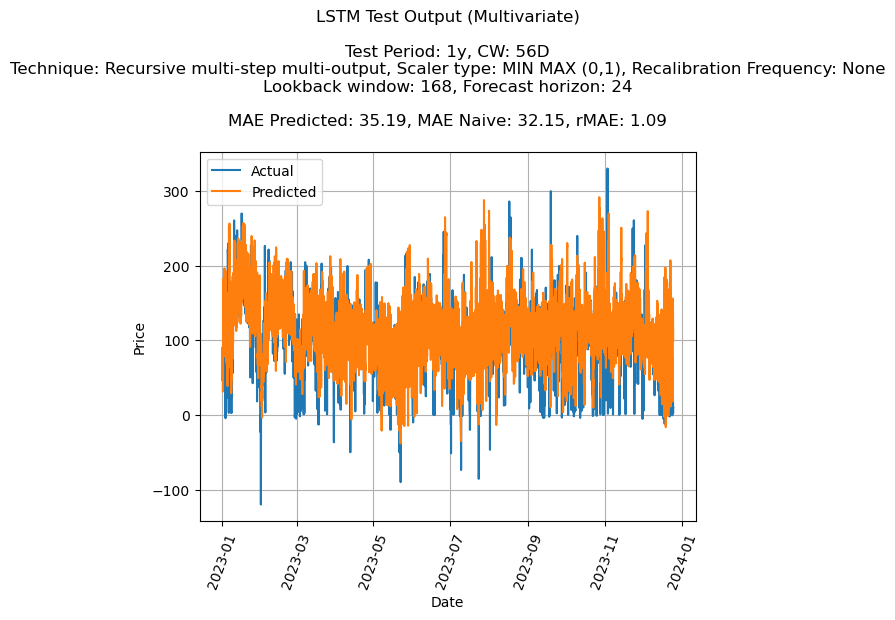

In [624]:
x_ticks = test_df.index[:-n_lookback]

title = f"""LSTM Test Output ({regression_type})\n
Test Period: {test_period}, CW: {calibration_window}
Technique: {multistep_technique}, Scaler type: {scaler_type}, Recalibration Frequency: {recalibration}
Lookback window: {lookback_window}, Forecast horizon: {forecast_horizon}\n
MAE Predicted: {round(mae_pred,2)}, MAE Naive: {round(mae_naive, 2)}, rMAE: {round(mae_pred/mae_naive, 2)}
"""

plt.plot(x_ticks, Y_actual, label="Actual")
plt.plot(x_ticks, Y_pred, label="Predicted")
# plt.plot(x_ticks, Y_pred_naive, label="Persistence", alpha=0.2)
plt.title(title)
plt.legend()
plt.xticks(rotation=70)
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()

In [218]:
print("7D Recalibration frequency MAX MIN: ", np.concatenate(Y_pred_list).max(), np.concatenate(Y_pred_list).min())
print("No recalibration MAX MIN: ", Y_pred.max(), Y_pred.min())

7D Recalibration frequency MAX MIN:  296.48114 -11.75234
No recalibration MAX MIN:  291.5155 13.436424


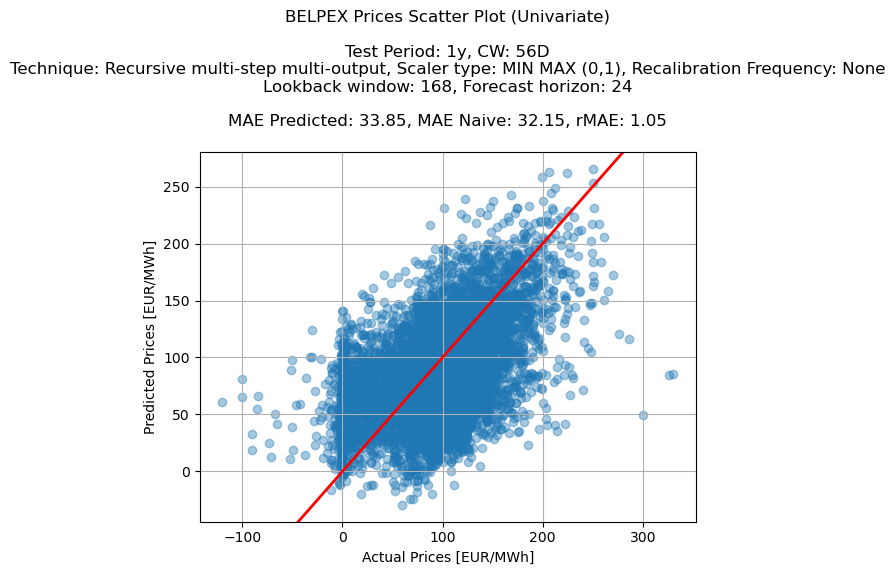

In [415]:
fig, ax = plt.subplots()

title =f"""
Test Period: {test_period}, CW: {calibration_window}
Technique: {multistep_technique}, Scaler type: {scaler_type}, Recalibration Frequency: {recalibration}
Lookback window: {lookback_window}, Forecast horizon: {forecast_horizon}\n
MAE Predicted: {round(mae_pred,2)}, MAE Naive: {round(mae_naive, 2)}, rMAE: {round(mae_pred/mae_naive, 2)}
"""

ax.axline((0, 0), slope=1, color='r', linewidth=2)
ax.scatter(x=Y_actual, y=Y_pred, alpha = 0.4)
ax.grid(True)
ax.set_xlabel("Actual Prices [EUR/MWh]")
ax.set_ylabel("Predicted Prices [EUR/MWh]")
plt.title(f"BELPEX Prices Scatter Plot ({regression_type})\n{title}")
plt.show()

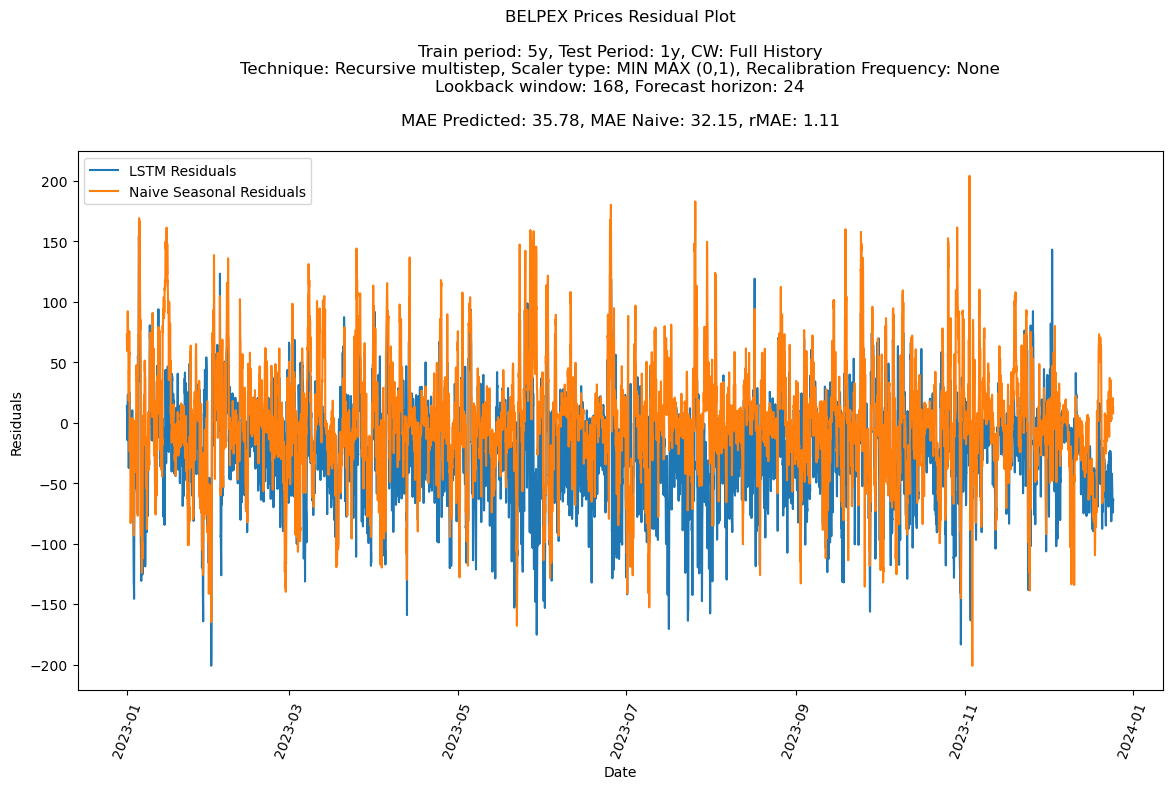

In [222]:
lstm_residuals = Y_actual - Y_pred
naive_residuals = Y_actual - Y_pred_naive

plt.figure(figsize=(14, 7))
plt.plot(x_ticks, lstm_residuals, label='LSTM Residuals')
plt.plot(x_ticks, naive_residuals, label='Naive Seasonal Residuals')
plt.title(f"BELPEX Prices Residual Plot\n{title}")
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.xticks(rotation=70)
plt.show()

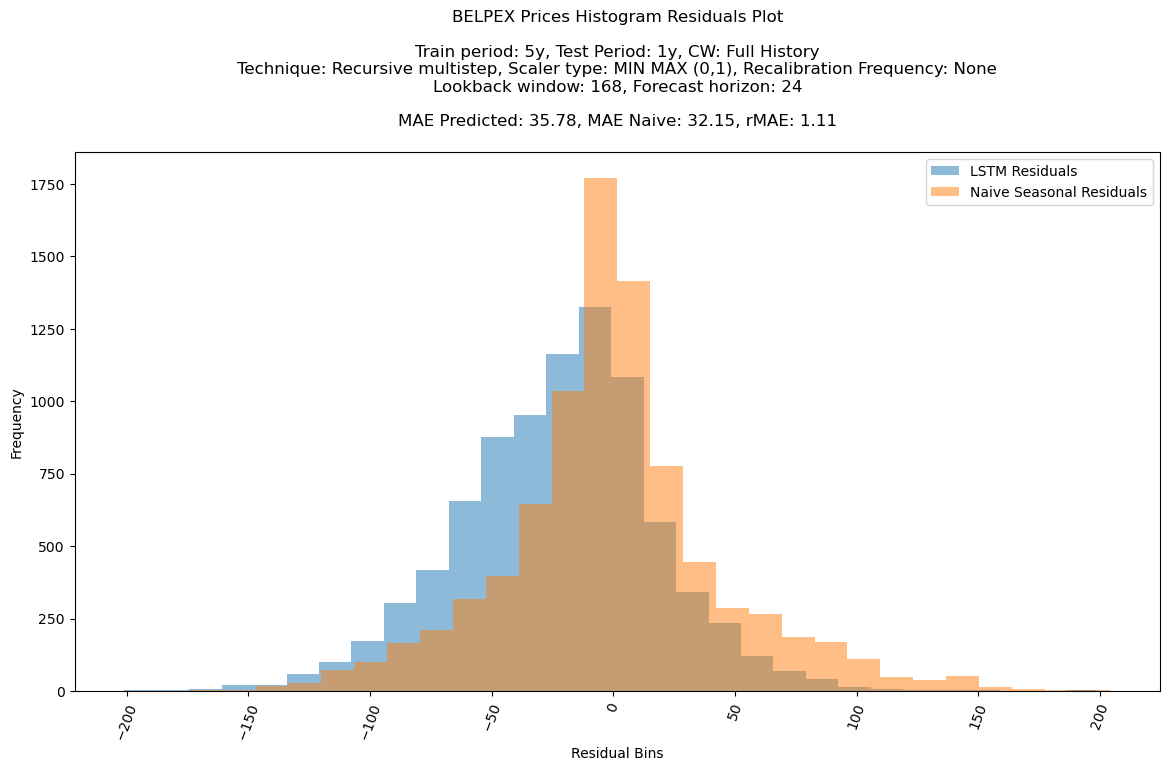

In [223]:
plt.figure(figsize=(14, 7))
plt.hist(lstm_residuals, bins=30, alpha=0.5, label='LSTM Residuals')
plt.hist(naive_residuals, bins=30, alpha=0.5, label='Naive Seasonal Residuals')
plt.title(f"BELPEX Prices Histogram Residuals Plot\n{title}")
plt.xlabel('Residual Bins')
plt.ylabel('Frequency')
plt.legend()
plt.xticks(rotation=70)
plt.show()

In [145]:
from helper_functions.dm import dm_test
from helper_functions.gw import GW

# numpy array with a p-value per hour for the univariate test

dm = dm_test(Y_actual,Y_pred,Y_pred_naive,h = 24, crit="MSE")

Y_actual_gw = Y_actual.reshape(-1, 24).astype(float)
Y_pred_gw = Y_pred.reshape(-1, 24).astype(float)
Y_pred_naive_gw = Y_pred_naive.reshape(-1, 24).astype(float)

gw = GW(Y_actual_gw, Y_pred_gw, Y_pred_naive_gw, norm=1, version='univariate')

print(f"Diabold Mariano Test: {dm}\nGiacomini-White Test: \n{gw}")

Diabold Mariano Test: dm_return(DM=-0.3691527734283082, p_value=0.7120229525493231)
Giacomini-White Test: 
[1.46114675e-05 5.19245458e-09 2.12447501e-07 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.65154061e-01 1.00000000e+00
 4.72300913e-02 6.83015892e-04 1.19982167e-02 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 4.78149187e-01
 0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 2.29262224e-02 2.49751600e-06 1.37445610e-13 1.62760084e-08]


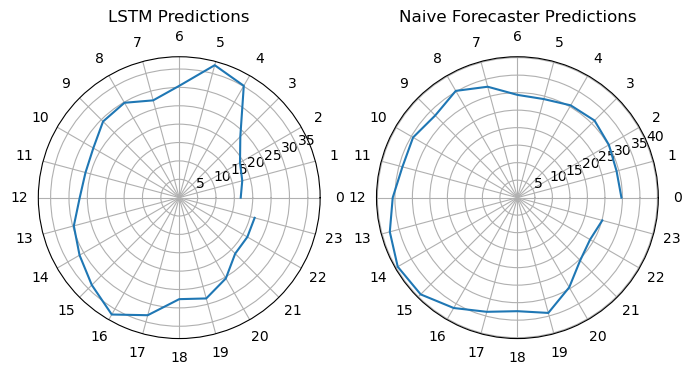

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Calculate MAE for each hour
mae_lstm = [mean_absolute_error(Y_actual_gw[:, i], Y_pred_gw[:, i]) for i in range(24)]
mae_naive = [mean_absolute_error(Y_actual_gw[:, i], Y_pred_naive_gw[:, i]) for i in range(24)]

# Convert hours to radians
hours = np.linspace(0, 2*np.pi, 24, endpoint=False)

# Create clock chart for LSTM predictions
plt.figure(figsize=(8, 8))
ax = plt.subplot(121, polar=True)
ax.plot(hours, mae_lstm)
ax.set_xticks(hours)
ax.set_xticklabels(range(24))
ax.set_title('LSTM Predictions')

# Create clock chart for naive forecaster predictions
ax = plt.subplot(122, polar=True)
ax.plot(hours, mae_naive)
ax.set_xticks(hours)
ax.set_xticklabels(range(24))
ax.set_title('Naive Forecaster Predictions')
# ax.set_yticklabels('MAE')
plt.show()

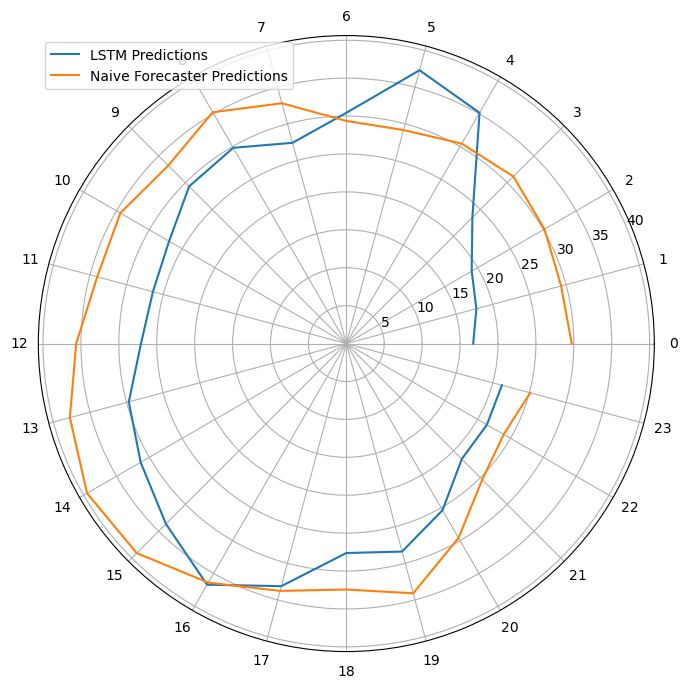

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Calculate MAE for each hour
mae_lstm = [mean_absolute_error(Y_actual_gw[:, i], Y_pred_gw[:, i]) for i in range(24)]
mae_naive = [mean_absolute_error(Y_actual_gw[:, i], Y_pred_naive_gw[:, i]) for i in range(24)]

# Convert hours to radians
hours = np.linspace(0, 2*np.pi, 24, endpoint=False)

# Create clock chart for LSTM and naive forecaster predictions
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.plot(hours, mae_lstm, label='LSTM Predictions')
ax.plot(hours, mae_naive, label='Naive Forecaster Predictions')
ax.set_xticks(hours)
ax.set_xticklabels(range(24))
ax.legend()

plt.show()

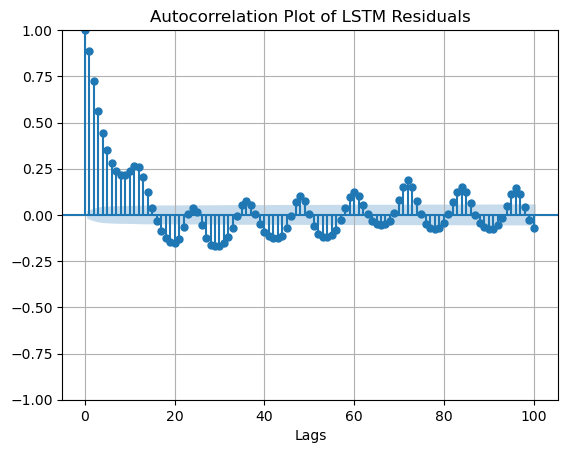

In [72]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(lstm_residuals, lags=100, title="Autocorrelation Plot of LSTM Residuals")
plt.xlabel("Lags")
# plt.xticks(ticks=[i in range(0, 101, 5)])
plt.grid(True)
plt.show()

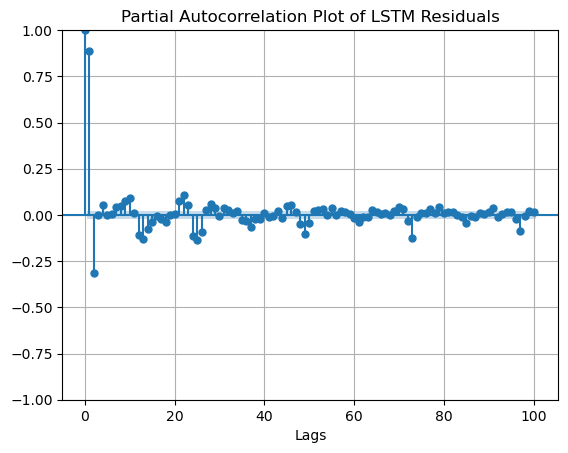

In [70]:
plot_pacf(lstm_residuals, lags=100, title="Partial Autocorrelation Plot of LSTM Residuals")
plt.xlabel("Lags")
plt.grid(True)
plt.show()